### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### §1 Introduction & Cleaning

In this notebook we're going to clean and analyse the UK.gov Raw Manual Counts dataset.

In the cleaning section (1) we're going to:
- Import the dataset (1.1)
- Calculate NaN values (1.2).
- Count missing values (1.3).
- Remove columns that will not be used in feature selection or have too many NaN values (1.4).
- Check the unique values in each categorical column (1.5).
  - Create new columns for each time category (1.5.1).
  - Create categorical columns for eacch time category for ease of use in modelling (1.5.2).
  - Save the cleaned dataframe to a CSV file (1.5.3).

- Provide some visualisations which show (1.6):
    - Time series line plot of data point counts. (1.6.1).
    - Heat map of data completeness (1.6.2).
    - Spatial distribtuion of data completness plot. (1.6.3).
    - Aggregated daily average vehilce volume vy region (1.6.4).
    - Road type & Road category vs road traffic volume (1.6.5).
    - Road traffic volume vs vehicle type (1.6.6).
   
### §2 Analysis
After having done a brief summary of the data. In the Analysis (2) section we're going to:
- Provide a regression analysis of how much certain variables play into traffic count (2.1).
- Carry out OLS Regression tests for different variables against All_motor_vehicles (2.2).

### §3 Conclusion
Summarise what has been carried out in this notebook.


---



### §1 Clean Data

Here the data is loaded and cleaned. Throughout we'll see that there was a need to remove many columns that will not be used in the model. We reformated Count_date to work in pandas.

### §1.1 Import dataset.

In [4]:
from graphviz import Digraph

dot = Digraph()

dot.node('A', 'Input Layer')
dot.node('B', 'Hidden Layer 1')
dot.node('C', 'Hidden Layer 2')
dot.node('D', 'Output Layer')

dot.edges(['AB', 'BC', 'CD'])
dot.render('network_diagram', format='png', view=True)  # Saves and shows the diagram


'network_diagram.png'

In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/individual_project/data/dft_traffic_counts_raw_counts.csv', parse_dates=['Count_date'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815504 entries, 0 to 4815503
Data columns (total 35 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Count_point_id                int64         
 1   Direction_of_travel           object        
 2   Year                          int64         
 3   Count_date                    datetime64[ns]
 4   hour                          int64         
 5   Region_id                     int64         
 6   Region_name                   object        
 7   Region_ons_code               object        
 8   Local_authority_id            int64         
 9   Local_authority_name          object        
 10  Local_authority_code          object        
 11  Road_name                     object        
 12  Road_category                 object        
 13  Road_type                     object        
 14  Start_junction_road_name      object        
 15  End_junction_road_name        ob

### §1.2 Parse datetime data:

In [5]:
print(df['Count_date'].iloc[:-10])

0         2014-06-25
1         2014-06-25
2         2014-06-25
3         2014-06-25
4         2014-06-25
             ...    
4815489   2020-06-05
4815490   2020-06-05
4815491   2020-06-05
4815492   2020-06-05
4815493   2020-06-05
Name: Count_date, Length: 4815494, dtype: datetime64[ns]


#### Dtype of Count_date column reformated successfully to datetime64[ns]

### §1.3 Count missing values:



In [6]:
missing_values = df.isnull().sum()
print(missing_values)

Count_point_id                        0
Direction_of_travel                   0
Year                                  0
Count_date                            0
hour                                  0
Region_id                             0
Region_name                           0
Region_ons_code                       0
Local_authority_id                    0
Local_authority_name                  0
Local_authority_code                  0
Road_name                             0
Road_category                         0
Road_type                             0
Start_junction_road_name        2634972
End_junction_road_name          2634912
Easting                               0
Northing                              0
Latitude                              0
Longitude                             0
Link_length_km                  2632824
Link_length_miles               2632824
Pedal_cycles                          0
Two_wheeled_motor_vehicles            0
Cars_and_taxis                        1


#### Here we can see high levels of nan values in the Start_junction_road_name and End_junction_road_name cloumns. As these columns are not of great importance to the aims of this project, the choice was made to drop both columns. All_HGVs will be the only column relating to HGVs as it has been decided keeping all the variables will be too computationally expensive and could cause overfitting in the model.

### §1.4 Remove columns that will not be used in feature selection or have too many NaN values:

In [7]:
# Drop columns that are not needed for the model and analysis
df_cleaned = df.drop(['Start_junction_road_name',
                     'End_junction_road_name',
                     'Link_length_km',
                     'Link_length_miles',
                     'Region_id',
                     'Region_ons_code',
                     'Local_authority_id',
                     'Local_authority_code',
                     'Easting',
                     'Northing',
                     'HGVs_2_rigid_axle',
                     'HGVs_3_rigid_axle',
                     'HGVs_4_or_more_rigid_axle',
                     'HGVs_3_or_4_articulated_axle',
                     'HGVs_5_articulated_axle',
                     'HGVs_6_articulated_axle',
                      'Road_name'], axis = 1)

print(df_cleaned. head(10))

   Count_point_id Direction_of_travel  Year Count_date  hour Region_name  \
0             749                   E  2014 2014-06-25     7    Scotland   
1             749                   E  2014 2014-06-25     8    Scotland   
2             749                   E  2014 2014-06-25     9    Scotland   
3             749                   E  2014 2014-06-25    10    Scotland   
4             749                   E  2014 2014-06-25    11    Scotland   
5             749                   E  2014 2014-06-25    12    Scotland   
6             749                   W  2014 2014-06-25    13    Scotland   
7             749                   W  2014 2014-06-25    14    Scotland   
8             749                   W  2014 2014-06-25    15    Scotland   
9             749                   W  2014 2014-06-25    16    Scotland   

  Local_authority_name Road_category Road_type   Latitude  Longitude  \
0        East Ayrshire            TA     Major  55.591636  -4.478606   
1        East Ayrsh

### §1.5 Calculate number of unique values for each categorical variable.

In [8]:
categorical_columns = ['Direction_of_travel', 'Region_name', 'Local_authority_name', 'Road_category', 'Road_type']

# Dictionary to hold the count of unique values per column
unique_counts = {col: df_cleaned[col].nunique() for col in categorical_columns}
print(unique_counts)

{'Direction_of_travel': 10, 'Region_name': 11, 'Local_authority_name': 211, 'Road_category': 6, 'Road_type': 2}


### §1.5.1 Make columns for time categories that will be used as features.

In [9]:
# Add columns to dataset with different time series
df_cleaned['Month'] = df_cleaned['Count_date'].dt.month
df_cleaned['Week'] = df_cleaned['Count_date'].dt.isocalendar().week
df_cleaned['Day'] = df_cleaned['Count_date'].dt.dayofweek

# Display the types to confirm all are expected datatypes
print(df_cleaned.dtypes)

Count_point_id                         int64
Direction_of_travel                   object
Year                                   int64
Count_date                    datetime64[ns]
hour                                   int64
Region_name                           object
Local_authority_name                  object
Road_category                         object
Road_type                             object
Latitude                             float64
Longitude                            float64
Pedal_cycles                           int64
Two_wheeled_motor_vehicles             int64
Cars_and_taxis                       float64
Buses_and_coaches                    float64
LGVs                                   int64
All_HGVs                             float64
All_motor_vehicles                   float64
Month                                  int32
Week                                  UInt32
Day                                    int32
dtype: object


### §1.5.2 Make time categories categorical and drop rows with NaN values.

In [10]:
import calendar

# Directly convert 'hour' to a categorical variable
df_cleaned['hour'] = pd.Categorical(df_cleaned['hour'])

# Define a mapping from day numbers to day names
days_of_week = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Map the 'Day' column to day names
df_cleaned['Day_of_Week'] = df_cleaned['Day'].map(days_of_week)

# Convert the 'Day_of_Week' column to a categorical data type with a specific order
df_cleaned['Day_of_Week'] = pd.Categorical(df_cleaned['Day_of_Week'],
                                           categories=list(days_of_week.values()),
                                           ordered=True)

# Create a dictionary mapping month numbers to names
months_of_year = {i: calendar.month_name[i] for i in range(1, 13)}
df_cleaned['Month'] = df_cleaned['Month'].map(months_of_year)
df_cleaned['Month'] = pd.Categorical(df_cleaned['Month'], categories=list(calendar.month_name[1:]), ordered=True)

print(df_cleaned[['Day_of_Week', 'Month', 'hour']].head(25))

   Day_of_Week Month hour
0    Wednesday  June    7
1    Wednesday  June    8
2    Wednesday  June    9
3    Wednesday  June   10
4    Wednesday  June   11
5    Wednesday  June   12
6    Wednesday  June   13
7    Wednesday  June   14
8    Wednesday  June   15
9    Wednesday  June   16
10   Wednesday  June   17
11   Wednesday  June   18
12   Wednesday  June    7
13   Wednesday  June    8
14   Wednesday  June    9
15   Wednesday  June   10
16   Wednesday  June   11
17   Wednesday  June   12
18   Wednesday  June   13
19   Wednesday  June   14
20   Wednesday  June   15
21   Wednesday  June   16
22   Wednesday  June   17
23   Wednesday  June   18
24      Monday   May   18


In [11]:
# Remove rows where the target variable is NaN
df_cleaned = df_cleaned.dropna()

In [12]:
# Check all months are included in data
print(df_cleaned['Month'].unique())
df_cleaned.dtypes
df_cleaned.isnull().sum()

['June', 'May', 'September', 'October', 'March', 'April', 'July', 'November', 'August']
Categories (12, object): ['January' < 'February' < 'March' < 'April' ... 'September' < 'October' <
                          'November' < 'December']


Count_point_id                0
Direction_of_travel           0
Year                          0
Count_date                    0
hour                          0
Region_name                   0
Local_authority_name          0
Road_category                 0
Road_type                     0
Latitude                      0
Longitude                     0
Pedal_cycles                  0
Two_wheeled_motor_vehicles    0
Cars_and_taxis                0
Buses_and_coaches             0
LGVs                          0
All_HGVs                      0
All_motor_vehicles            0
Month                         0
Week                          0
Day                           0
Day_of_Week                   0
dtype: int64

#### Not all months of the year are included in the dataset.

### §1.5.3 Save the cleaned dataframe to a csv file for usability in the model notebook.

In [2]:
df_cleaned.to_csv('/content/drive/MyDrive/individual_project/data/cleaned_data.csv', index=False)

NameError: name 'df_cleaned' is not defined

## §1.6 Visualise the data.




### §1.6.1 Calculate completeness of data from a temporal aspect using a time series line plot.

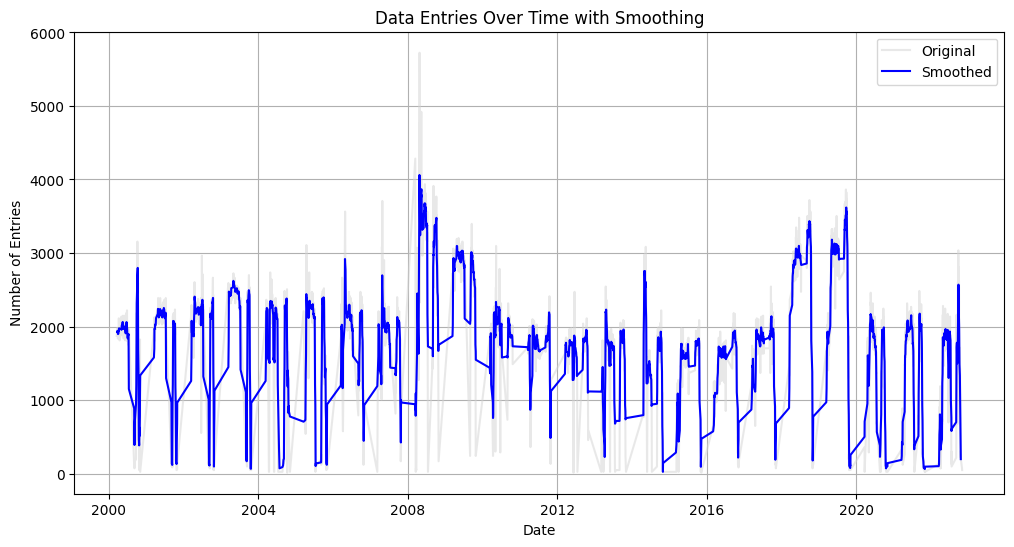

In [13]:
import matplotlib.pyplot as plt

# Group by 'Count_date' and count non-null entries in any column (using 'size' to count rows)
data_counts = df_cleaned.groupby('Count_date').size()

# Calculate rolling average for smoothing, window size can be adjusted
rolling_window_size = 7  # This is a 7-day rolling window
smoothed_data = data_counts.rolling(window=rolling_window_size, center=True).mean()

# Plotting the original data
plt.figure(figsize=(12, 6))
plt.plot(data_counts.index, data_counts, alpha=0.5, label='Original', linestyle='-', color='lightgray')

# Plotting the smoothed data
plt.plot(smoothed_data.index, smoothed_data, label='Smoothed', linestyle='-', color='blue')
plt.title('Data Entries Over Time with Smoothing')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.legend()
plt.grid(True)
plt.show()

### §1.6.2 Calculate heatmap of data completeness by week and day.

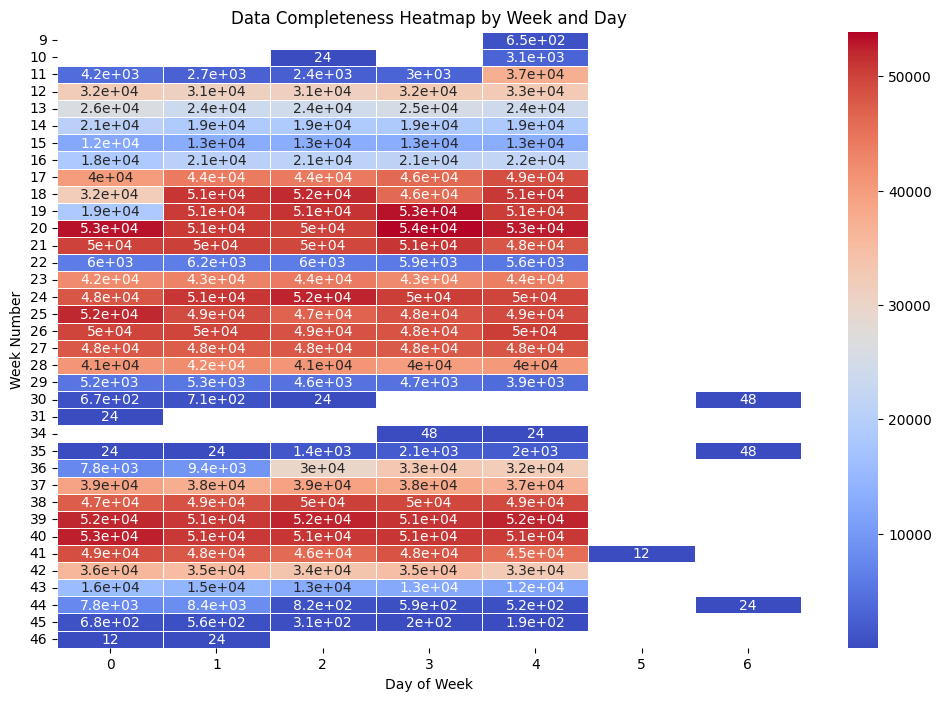

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table
pivot_table = df_cleaned.pivot_table(index='Week', columns='Day', values='Count_date', aggfunc='count')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Data Completeness Heatmap by Week and Day')
plt.xlabel('Day of Week')
plt.ylabel('Week Number')
plt.show()

### §1.6.3 Spatial distribtuion of data completness plot.

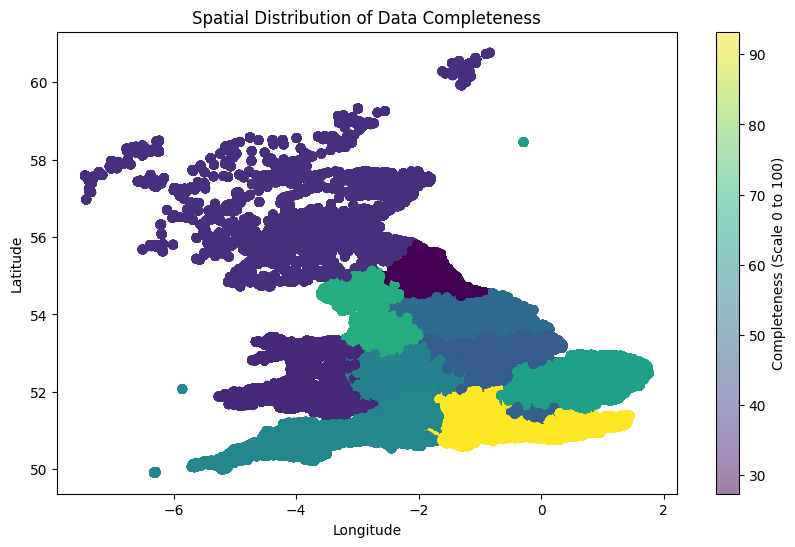

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Check if 'Completeness' needs to be recalculated or not
if 'Completeness' not in df_cleaned.columns:
    min_date = df_cleaned['Count_date'].min()
    max_date = df_cleaned['Count_date'].max()
    expected_days = pd.date_range(start=min_date, end=max_date, freq='D').size
    actual_entries = df_cleaned.groupby('Region_name')['Count_date'].count()
    completeness = actual_entries / expected_days
    completeness = completeness.reset_index()
    completeness.columns = ['Region_name', 'Completeness']
    df_cleaned = df_cleaned.merge(completeness, on='Region_name', how='left')

# Plotting:
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['Longitude'], df_cleaned['Latitude'], c=df_cleaned['Completeness'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Completeness (Scale 0 to 100)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Data Completeness')
plt.show()

### §1.6.4 Aggregate data by region and plot average number of recorded counts per region.

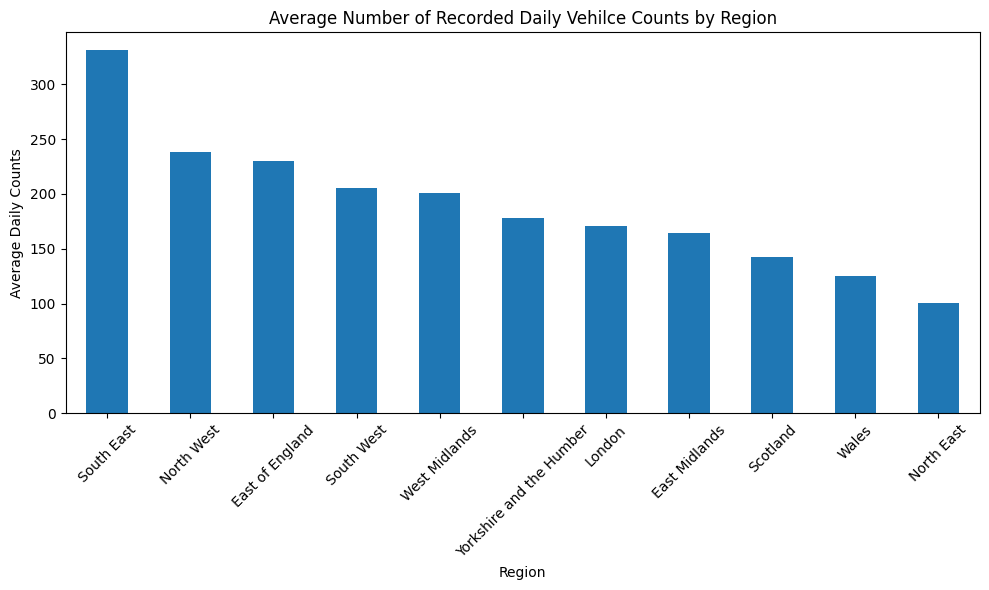

In [14]:
import matplotlib.pyplot as plt

# Group data by region and date, then count records for each day
daily_counts_by_region = df.groupby(['Region_name', df['Count_date'].dt.date]).size()

# Calculate the average number of records for each region
average_daily_counts_by_region = daily_counts_by_region.groupby(level=0).mean()

# Sort regions by their average daily count for better visualization
sorted_average_counts = average_daily_counts_by_region.sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sorted_average_counts.plot(kind='bar')

# Adding title and labels
plt.title('Average Number of Recorded Daily Vehilce Counts by Region')
plt.xlabel('Region')
plt.ylabel('Average Daily Counts')

# Show the plot
plt.xticks(rotation=45)  # Rotate region names for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


### §1.6.5 Visualise traffic volume vs road type and road category.

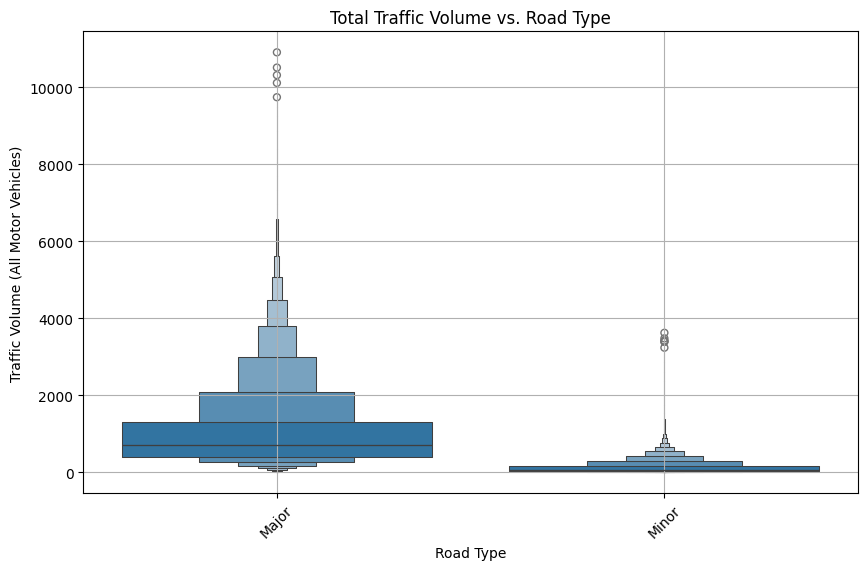

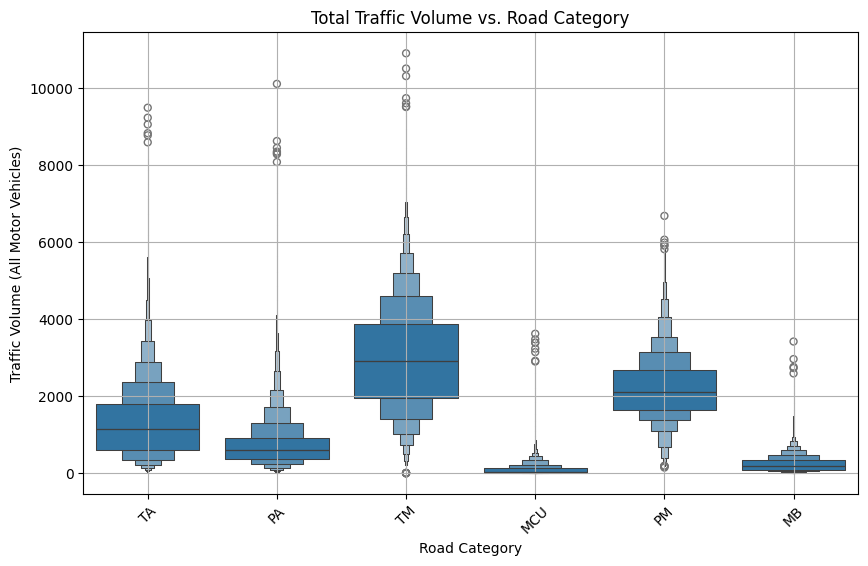

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot based on traffic volume vs. road type
plt.figure(figsize=(10, 6))
sns.boxenplot(data=df_cleaned, x=df_cleaned['Road_type'], y=df_cleaned['All_motor_vehicles'])
plt.title('Total Traffic Volume vs. Road Type')
plt.xlabel('Road Type')
plt.ylabel('Traffic Volume (All Motor Vehicles)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Scatter plot based on traffic volume vs. road category
plt.figure(figsize=(10, 6))
sns.boxenplot(data=df_cleaned, x='Road_category', y='All_motor_vehicles')
plt.title('Total Traffic Volume vs. Road Category')
plt.xlabel('Road Category')
plt.ylabel('Traffic Volume (All Motor Vehicles)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### §1.6.6 Visualise traffic volume vs vehicle type.

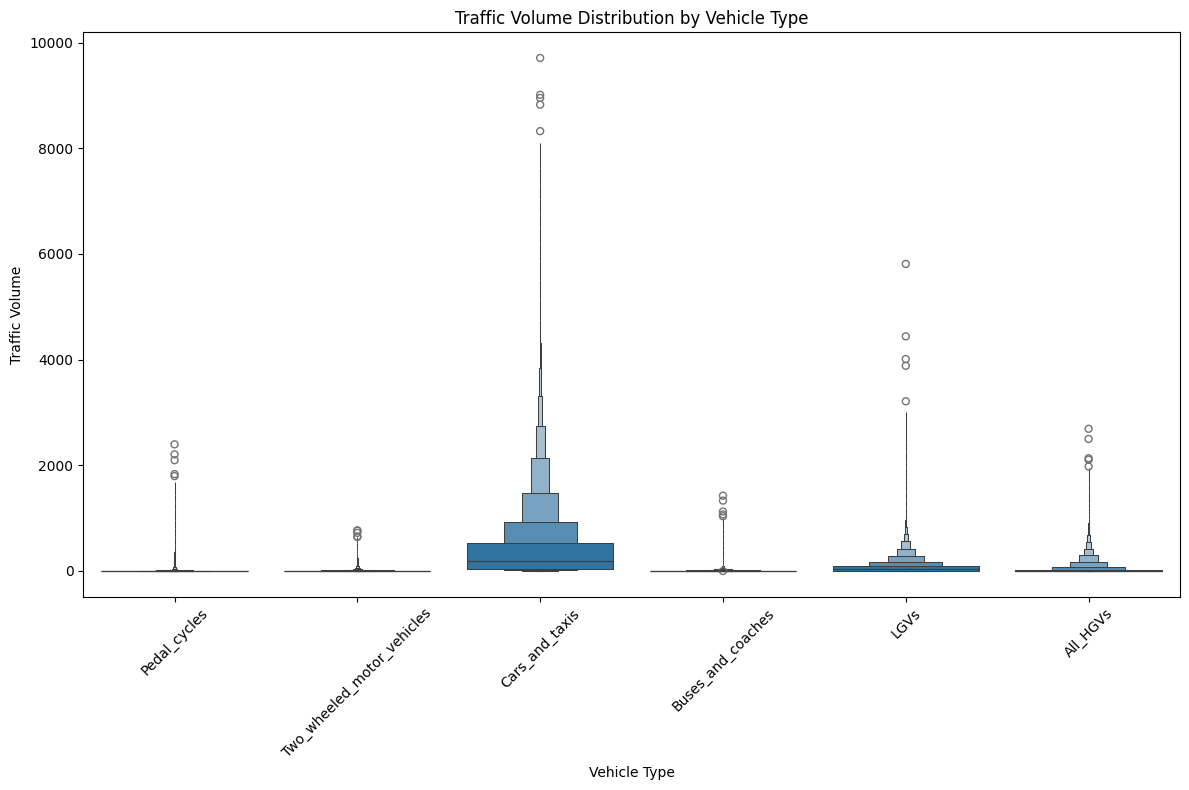

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data
melted_df = df_cleaned.melt(value_vars=['Pedal_cycles', 'Two_wheeled_motor_vehicles', 'Cars_and_taxis',
                                'Buses_and_coaches', 'LGVs', 'All_HGVs'],
                    var_name='Vehicle_Type', value_name='Traffic_Volume')

# Ensure the data types are correct
melted_df['Traffic_Volume'] = pd.to_numeric(melted_df['Traffic_Volume'], errors='coerce')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 8))
sns.boxenplot(x='Vehicle_Type', y='Traffic_Volume', data=melted_df)
plt.xticks(rotation=45)
plt.xlabel('Vehicle Type')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Distribution by Vehicle Type')
plt.tight_layout()
plt.show()

### §2 Analysis

### §2.1 Regression analysis of the variables. Using the predictor variables:
- Count_point_id
- Direction_of_travel
- Month
- Day_of_Week
- Hour
- Region_name
- Road_name
- Road_category
- Road_type
- Latitude
- Longitude

### With the dependant variable as:
- All_motor_vehicles

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Select columns to use
X = df_cleaned[['Count_point_id', 'Direction_of_travel', 'Year', 'Month', 'Day', 'hour', 'Region_name',
                'Road_name', 'Road_category', 'Road_type']]

y = df_cleaned['All_motor_vehicles']

# Handle categorical variables
categorical_cols = [cname for cname in X.columns if
                    X[cname].dtype == "object" or cname in ['Hour']]
numerical_cols = [cname for cname in X.columns if
                  X[cname].dtype in ['int64', 'float64'] and cname not in categorical_cols]

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that processes the data and then runs the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Fit the model
model.fit(X, y)

# Retrieve the regression coefficients from the model
# Note: This step requires access to the named steps of the pipeline
coefficients = model.named_steps['regressor'].coef_
features = (numerical_cols +
            list(model.named_steps['preprocessor'].named_transformers_['cat']
                 .get_feature_names_out()))

# Print the coefficients along with their corresponding feature names
print("Coefficients of the Model:")
for feature, coef in zip(features, coefficients):
    print(f"{feature}: {coef}")

# You can also show the intercept
intercept = model.named_steps['regressor'].intercept_
print(f"Intercept: {intercept}")

Coefficients of the Model:
Count_point_id: 41.73488273410869
Year: 13.986634102839442
Direction_of_travel_C: 85.80171150144913
Direction_of_travel_E: 14.16100296527251
Direction_of_travel_J: 13.604357102422938
Direction_of_travel_N: 7.52454800461743
Direction_of_travel_S: 6.291142929565382
Direction_of_travel_W: 11.926445481652884
Direction_of_travel_e: -77.54298407333017
Direction_of_travel_n: 7.599433025273982
Direction_of_travel_s: 13.156033729035862
Direction_of_travel_w: -82.52169001206414
Region_name_East Midlands: -22.45868504746206
Region_name_East of England: -19.29811715479315
Region_name_London: 129.27685302965992
Region_name_North East: 78.15964130590234
Region_name_North West: -7.638539024835651
Region_name_Scotland: -21.585461346190417
Region_name_South East: 17.73519244928849
Region_name_South West: -52.32042411589147
Region_name_Wales: -102.03509334361324
Region_name_West Midlands: 6.239133171337447
Region_name_Yorkshire and the Humber: -6.074501146373967
Road_name_A1: 

### Summarise the coefficients:

In [ ]:
import pandas as pd

# Create a DataFrame from the features and coefficients
coeff_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})
coeff_df['Absolute_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Absolute_Coefficient', ascending=False)
print(coeff_df)

              Feature  Coefficient  Absolute_Coefficient
722    Road_name_A282  3498.040517           3498.040517
3987    Road_name_M25  2930.195139           2930.195139
4011    Road_name_M60  2543.043389           2543.043389
3989    Road_name_M27  1991.403654           1991.403654
3978     Road_name_M1  1987.966287           1987.966287
...               ...          ...                   ...
2963  Road_name_B4166     0.321648              0.321648
2485  Road_name_B2124     0.131201              0.131201
21          Year_2008     0.115297              0.115297
3366  Road_name_B5218    -0.011307              0.011307
36             Hour_0    -0.000003              0.000003

[4039 rows x 3 columns]


### §2.2 Carry out OLS Regression tests for different variables against All_motor_vehicles.

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fitting a model with the categorical variable
model = ols('All_motor_vehicles ~ C(Road_type)', data=df_cleaned).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     All_motor_vehicles   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                 2.113e+06
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:58:46   Log-Likelihood:            -3.8312e+07
No. Observations:             4815489   AIC:                         7.662e+07
Df Residuals:                 4815487   BIC:                         7.662e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1047.34

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fitting a model with the categorical variable
model = ols('All_motor_vehicles ~ C(Road_category)', data=df_cleaned).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     All_motor_vehicles   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                 1.462e+06
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:02:36   Log-Likelihood:            -3.6965e+07
No. Observations:             4815489   AIC:                         7.393e+07
Df Residuals:                 4815483   BIC:                         7.393e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fitting a model with the categorical variable
model = ols('All_motor_vehicles ~ C(Direction_of_travel)', data=df_cleaned).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     All_motor_vehicles   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     164.2
Date:                Fri, 26 Apr 2024   Prob (F-statistic):          1.49e-312
Time:                        20:05:44   Log-Likelihood:            -3.9187e+07
No. Observations:             4815489   AIC:                         7.837e+07
Df Residuals:                 4815479   BIC:                         7.837e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
from statsmodels.formula.api import ols

# Fitting a model with the categorical variable
model = ols('All_motor_vehicles ~ C(Region_name)', data=df_cleaned).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     All_motor_vehicles   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     6758.
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:07:35   Log-Likelihood:            -3.9155e+07
No. Observations:             4815489   AIC:                         7.831e+07
Df Residuals:                 4815478   BIC:                         7.831e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fitting a model with the categorical variable
model = ols('All_motor_vehicles ~ Month + Day_of_Week + hour', data=df_cleaned).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     All_motor_vehicles   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2538.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:26:39   Log-Likelihood:            -3.9168e+07
No. Observations:             4815489   AIC:                         7.834e+07
Df Residuals:                 4815472   BIC:                         7.834e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fitting a model with the categorical variable
model = ols('All_motor_vehicles ~ hour + Day_of_Week', data=df_cleaned).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     All_motor_vehicles   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     386.4
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:36:25   Log-Likelihood:            -3.9187e+07
No. Observations:             4815489   AIC:                         7.837e+07
Df Residuals:                 4815481   BIC:                         7.837e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The OLS Regression tests show that Road_type and Road_category play a large role in the outcome of All_motor_vehicles, with an R-Squared value of 0.305 and 0.603 respectively.

All other variables are statistically significant in the tests but do not have similarly high R-Squared values.

When plotting Day_of_Week and hour, we can see that certain days such as Saturday and Sunday have higher coefficients, which is what we would probably expect.

### § 3 Conclusions:

In this notebook, we prepared our dataset for advanced analytical tasks aimed at predicting traffic volumes (All_motor_vehicles). Our process involved cleaning the data by handling missing values and ensuring consistency in time recordings. We transformed the Count_date into multiple granular fields such as Year, Month, Week, Day, and hour, and converted these into categorical formats to capture their influence on traffic patterns effectively.

Using an OLS regression model, we analysed the relationship between these time-based variables and traffic volumes, identifying key trends like yearly decreases in traffic and variations across different times that suggest seasonal and daily patterns. However, the regression diagnostics indicated issues with normality and multicollinearity, suggesting a need for further model refinement.

This analysis lays a solid foundation for the next step, where we will build a predictive model in a subsequent notebook. This future work will focus on addressing the identified issues and applying machine learning techniques to enhance predictive accuracy and provide deeper insights into traffic management.